In [1]:
import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt

#my functions
from Plot import plot_cv, plot_img

In [2]:
path = '../../../Data/obj.jpg'
img_rgb = cv.imread(path, cv.IMREAD_COLOR_RGB)
img = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
img_rgb.shape, img.shape

((3000, 3558, 3), (3000, 3558))

In [3]:
def reflection(img):
    return np.flip(img, axis=1)

In [4]:
#img = reflection(img)
#img_rgb = reflection(img_rgb)

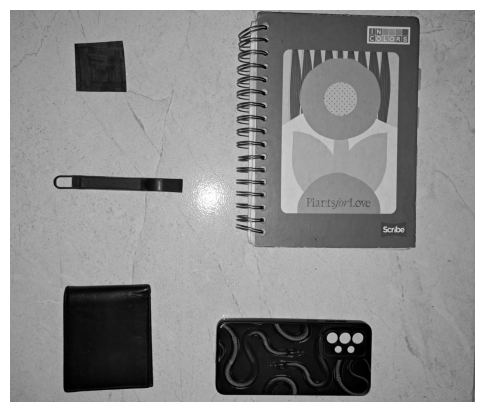

In [5]:
plot_img(img)

In [6]:
blur = cv.GaussianBlur(img, (7,7), 0)

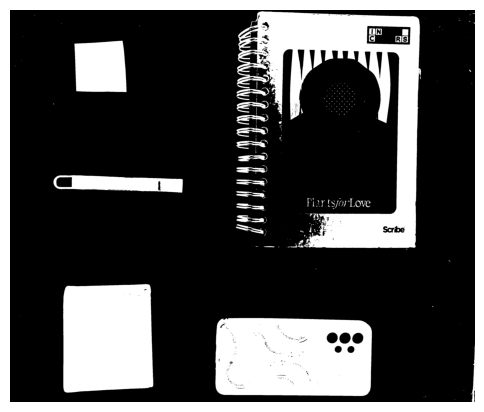

In [7]:
#thresh = cv.adaptiveThreshold(mask, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 35, 10)
_, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plot_img(thresh)

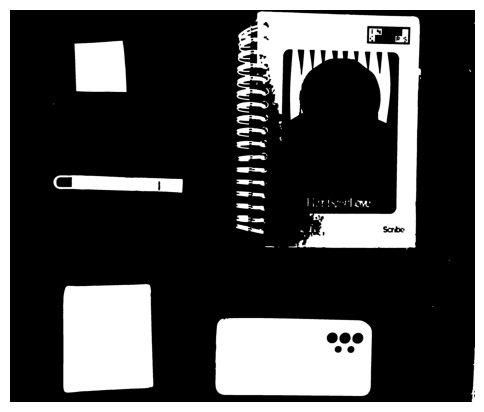

In [8]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
th = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=2)  # unir bordes
th = cv.morphologyEx(th, cv.MORPH_OPEN,  kernel, iterations=1)
plot_img(th)

In [9]:
cnts, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [10]:
def rect_info(contour):
    rect = cv.minAreaRect(contour)  #((cx,cy),(w,h),angle)
    (cx,cy), (bw,bh), angle = rect
    box = cv.boxPoints(rect)
    box = np.intp(box)
    length = max(bw,bh)
    width = min(bw,bh)
    area = cv.contourArea(contour)
    return {'rect': rect, 'box': box, 'Lpx': float(length), 'Wpx': float(width), 'area': float(area), 'center': (cx,cy)}

infos = [rect_info(c) for c in cnts if cv.contourArea(c) > 5000]

In [11]:
candidates = []
h, w = img.shape
for i in infos:
    length = i['Lpx']
    width = i['Wpx']
    ar = length / width if width > 0 else 999
    cx,cy = i['center']
    score = 0
    score += abs(ar-1.0)*2.0
    score += (cx/w) * 0.8 + (cy/h) * 0.8
    score += (i['area'] / (w*h)) * 5.0
    candidates.append((score, i))

In [12]:
ref = sorted(candidates, key=lambda x: x[0])[0][1] if candidates else None
pixel_cm = None
if ref is not None:
    px = (ref['Lpx'] + ref['Wpx']) / 2.0
    pixel_cm = px / 5.0

In [ ]:
annot = img_rgb.copy()
cv.drawContours(annot, [ref['box']], 0, (0,255,0), 4)
rc = np.array(ref['center'])

rows = []
for k, info in enumerate(infos, 1):
    #obj reference
    if np.linalg.norm(np.array(info['center']) - rc) < 20:
        continue
    Lcm = info['Lpx']/pixel_cm
    Wcm = info['Wpx']/pixel_cm
    if Wcm > Lcm: Lcm, Wcm = Wcm, Lcm
    cv.drawContours(annot, [info['box']], 0, (0,255,0), 4)
    x,y = map(int, info['center'])
    cv.putText(annot, f"{Lcm:.1f} x {Wcm:.1f} cm", (x-80,y), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

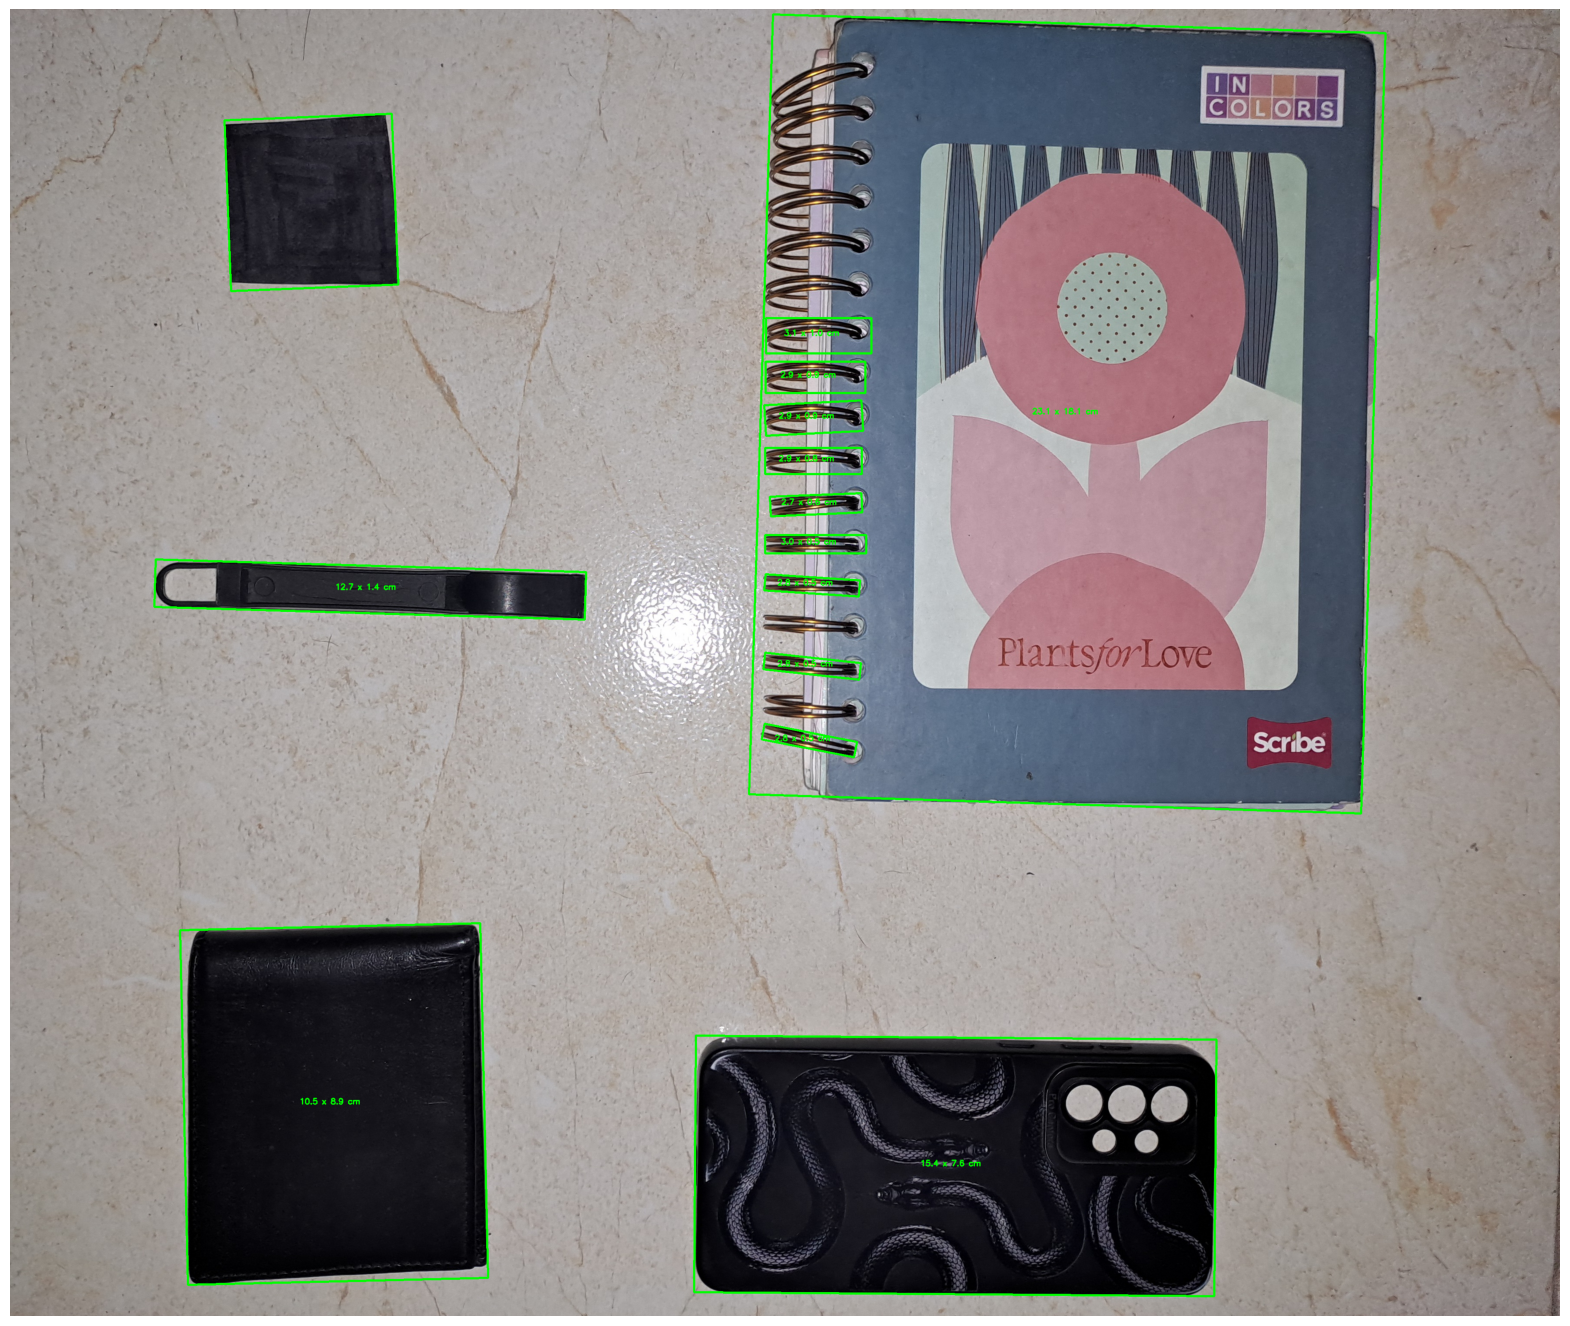

In [14]:
plot_img(annot, size=(20, 18))